# **Multimodal Neurons**

## Interpreting multimodal information in artificial neural networks

---

This notebook presents our research and experiments focused on the interpretability of multimodal neurons. It documents the methodologies, tests, and analyses we conducted to gain insights into how these neurons process and integrate multimodal conceptual information.

This is the structure in which we have organized our code:
```
├── data/                           	# -> Data folder (datasets, images, etc.)
├── results/                            # -> Results of our experiments
├── lucent/                             # -> Extended lucent framework
└── neuron_ids.txt                      # -> Neuron/channel ids for each learned "concept"
```

## Environment configuration

In [1]:
# For running this project in a hosted runtime

# Mount drive
# from google.colab import drive
# drive.mount('/content/drive')

# Project directory (change this to the Google Drive directory in which you have saved the project)
# %cd /content/drive/MyDrive/university/roes/multimodal neurons/

# Choose your path (for collaboration) - run in a hosted runtime
# curr_path = "/content/drive/MyDrive/university/roes/multimodal neurons/"

curr_path = "./" # run locally

# "PLAY" IN YOUR OWN COPY

In [5]:
# Environment configuration

# Dependencies and imports
# !pip install torch torchvision torchaudio ftfy regex tqdm deeplake
# !pip install git+https://github.com/openai/CLIP.git # CLIP
# !pip install torch-lucent # don't use this version, we have extended the lucent framework
# !pip install git+https://github.com/microsoft/CLAP.git # CLAP
# !pip install laion-clap # or this implementation of CLAP

import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import random
import os
import torch.nn as nn
from tqdm import tqdm
import time
import re
import itertools
from PIL import Image, ImageDraw, ImageFont
from torchvision import transforms, datasets
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.datasets import ImageNet, ImageFolder
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

import clip
from msclap import CLAP
import laion_clap

import deeplake
import fiftyone as fo
import fiftyone.zoo as foz

from lucent.optvis import render, param, transform, objectives
from lucent.misc.io.showing import animate_sequence
from lucent.modelzoo.util import get_model_layers
from lucent.misc.io import show
from lucent.optvis.param.color import to_valid_rgb

from transformers import AutoProcessor, AutoModel

import nltk
nltk.download('words')
from nltk.corpus import words

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Data
data_path = curr_path + "data/"

[nltk_data] Downloading package words to /home/angelos/nltk_data...
[nltk_data]   Package words is already up-to-date!


## CLIP model

Initially, we will reproduce most of the techniques and experiment results showcased in the [OpenAI Multimodal Neurons](https://distill.pub/2021/multimodal-neurons/#conditional-probability) paper, particularly for the **CLIP RN50x4** model.

In [ ]:
# CLIP available models

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
# Load the CLIP model

model, preprocess = clip.load("RN50x4", device=device)
# model, preprocess = AutoModel.from_pretrained("facebook/metaclip-b32-400m"), AutoProcessor.from_pretrained("facebook/metaclip-b32-400m") # MetaCLIP

model.eval()

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(80, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

## Zero-shot classification

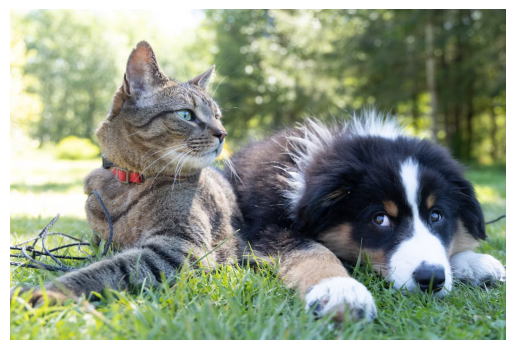

This is a dog: 0.0014295578002929688
This is a cat: 0.0018072128295898438
This is a dog and a cat: 0.99658203125


In [ ]:
# Example usage (zero-shot classification)

# Show image
image = Image.open(data_path + "dog_cat.jpg")
plt.imshow(image)
plt.axis('off')
plt.show()

# Preprocess image
image = preprocess(Image.open(data_path + "dog_cat.jpg")).unsqueeze(0).to(device)

# Tokenize text
texts = ["This is a dog", "This is a cat", "This is a dog and a cat"]
text_tokens = clip.tokenize(texts).to(device)

# Calculate similarity
with torch.no_grad():
  image_features = model.encode_image(image)
  text_features = model.encode_text(text_tokens)

  logits_per_image, logits_per_text = model(image, text_tokens)
  probs = logits_per_image.softmax(dim=-1).cpu().numpy()

for i, text in enumerate(texts):
    print(f"{text}: {probs[0][i]}")

## Feature visualization

In [ ]:
# Vision side of the CLIP model

vision_side = model.visual
# vision_side = model.vision_model # MetaCLIP -> transformer-based architecture

In [ ]:
# Vision side model layers

layers = get_model_layers(vision_side)
print(layers)

['conv1', 'bn1', 'relu1', 'conv2', 'bn2', 'relu2', 'conv3', 'bn3', 'relu3', 'avgpool', 'layer1', 'layer1_0', 'layer1_0_conv1', 'layer1_0_bn1', 'layer1_0_relu1', 'layer1_0_conv2', 'layer1_0_bn2', 'layer1_0_relu2', 'layer1_0_avgpool', 'layer1_0_conv3', 'layer1_0_bn3', 'layer1_0_relu3', 'layer1_0_downsample', 'layer1_0_downsample_-1', 'layer1_0_downsample_0', 'layer1_0_downsample_1', 'layer1_1', 'layer1_1_conv1', 'layer1_1_bn1', 'layer1_1_relu1', 'layer1_1_conv2', 'layer1_1_bn2', 'layer1_1_relu2', 'layer1_1_avgpool', 'layer1_1_conv3', 'layer1_1_bn3', 'layer1_1_relu3', 'layer1_2', 'layer1_2_conv1', 'layer1_2_bn1', 'layer1_2_relu1', 'layer1_2_conv2', 'layer1_2_bn2', 'layer1_2_relu2', 'layer1_2_avgpool', 'layer1_2_conv3', 'layer1_2_bn3', 'layer1_2_relu3', 'layer1_3', 'layer1_3_conv1', 'layer1_3_bn1', 'layer1_3_relu1', 'layer1_3_conv2', 'layer1_3_bn2', 'layer1_3_relu2', 'layer1_3_avgpool', 'layer1_3_conv3', 'layer1_3_bn3', 'layer1_3_relu3', 'layer2', 'layer2_0', 'layer2_0_conv1', 'layer2_0_bn

100%|███████████████████████████████████████████████████| 512/512 [00:24<00:00, 20.69it/s]



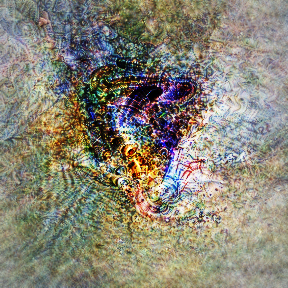

In [ ]:
# Define the layer and neuron/channel for feature visualization

# Note:
# * Channel optimization objective results in a repeating pattern
# * Neuron optimization objective shows spatial preferences

layer_name = "layer4_5_conv3"
neuron_channel_index = 1093 # 1739 is evil, 1512 is happy, 89 is the "Donald Trump neuron"
image_path = f"results/feature_vis_neuron_{layer_name}_{neuron_channel_index}.png"

batch_param_f = lambda: param.image(288, batch=1, decorrelate=True)
obj = objectives.neuron(layer_name, neuron_channel_index)

_ = render.render_vis(vision_side, obj, batch_param_f, show_inline=True, save_image=True, image_name=image_path, thresholds=(512,))
# _ = render.render_vis(vision_side, "layer3_3_conv3:168", show_inline=True) # or this

100%|███████████████████████████████████████████████████| 512/512 [00:25<00:00, 19.79it/s]



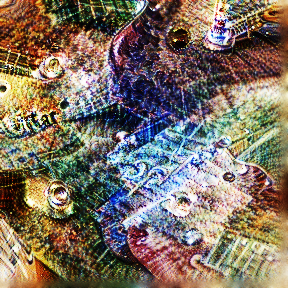

In [ ]:
# Here we try different tranformations for regularization

layer_name = "layer4_5_relu3"
neuron_channel_index = 1093 # 1739 is evil, 1512 is happy, 89 is the "Donald Trump neuron"
image_path = f"results/feature_vis_channel_{layer_name}_{neuron_channel_index}.png"

batch_param_f = lambda: param.image(288, batch=1, decorrelate=True)
obj = objectives.channel(layer_name, neuron_channel_index)

tforms = [ # we can experiment with these transformations
        transform.pad(2, mode='constant', constant_value=.5),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.random_scale([0.995**n for n in range(-5, 80)] + [0.998**n for n in 2 * list(range(20, 40))]),
        transform.random_rotate(list(range(-20, 20))+list(range(-10, 10))+list(range(-5, 5)) + 5 * [0]),
        transform.jitter(2)
]

_ = render.render_vis(vision_side, obj, batch_param_f, transforms=tforms, show_inline=True, save_image=True, image_name=image_path, thresholds=(512,))

100%|███████████████████████████████████████████████████| 512/512 [00:28<00:00, 17.75it/s]



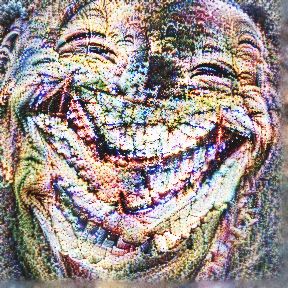

In [ ]:
# Define the layer and neuron/channel for feature visualization - let's try other objectives (e.g. adding a blur alpha term) -> interesting results (happy face)

layer_name = "layer4_5_bn3"
neuron_channel_index = 1512 # 1739 is evil, 1512 is happy, 89 is the "Donald Trump neuron"
image_path = f"results/feature_vis_channel_obj_{layer_name}_{neuron_channel_index}.png"

batch_param_f = lambda: param.image(288, batch=1, decorrelate=True, alpha=True)
obj = objectives.channel(layer_name, neuron_channel_index) - 1e2 * objectives.blur_alpha_each_step() # we experiment with this

tforms = [ # we can experiment with these transformations
        transform.pad(2, mode='constant', constant_value=.5),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.random_scale([0.995**n for n in range(-5, 80)] + [0.998**n for n in 2 * list(range(20, 40))]),
        transform.random_rotate(list(range(-20, 20))+list(range(-10, 10))+list(range(-5, 5)) + 5 * [0]),
        transform.jitter(2),
        transform.collapse_alpha_random()
]

_ = render.render_vis(vision_side, obj, batch_param_f, transforms=tforms, show_inline=True, save_image=True, image_name=image_path, thresholds=(512,))

## Deep dream

100%|███████████████████████████████████████████████████| 512/512 [00:26<00:00, 19.37it/s]



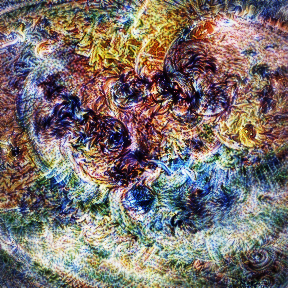

In [ ]:
# Define the layer for feature visualization - deepdream

layer_name = "layer4_5_conv3"
image_path = f"results/feature_vis_deepdream_{layer_name}.png"

batch_param_f = lambda: param.image(288, batch=1, decorrelate=True)
obj = objectives.deepdream(layer_name)

_ = render.render_vis(vision_side, obj, batch_param_f, show_inline=True, save_image=True, image_name=image_path, thresholds=(512,))

## Neuron interactions

100%|███████████████████████████████████████████████████| 512/512 [00:36<00:00, 14.12it/s]



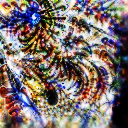
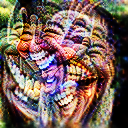
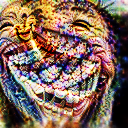
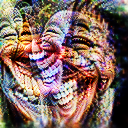
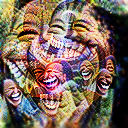
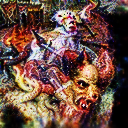

In [ ]:
# Neuron interactions (combined neurons, interpolation, etc.) -> very interesting, we will delve into this as soon as possible

# I will write the code shortly... (we must experiment more)

# * Negative visualizations
# layer_name = "layer4_5_bn3"
# neuron_channel_index = 1257 # 1739 is evil, 1512 is happy, 1257 is west africa
# image_path = f"results/feature_vis_negative_{layer_name}_{neuron_channel_index}.png"

# batch_param_f = lambda: param.image(288, batch=2, decorrelate=True)
# obj = objectives.channel(layer_name, neuron_channel_index, batch=1) - objectives.channel(layer_name, neuron_channel_index, batch=0)

# _ = render.render_vis(vision_side, obj, batch_param_f, show_inline=True, save_image=True, image_name=image_path, thresholds=(512,))

# * Interpolation
def interpolate_param_f():
  params, image_f = param.fft_image((6, 3, 128, 128))
  shared = [
      param.lowres_tensor((6, 3, 128, 128), (1, 3, 128//2, 128//2)),
      param.lowres_tensor((6, 3, 128, 128), (1, 3, 128//4, 128//4)),
      param.lowres_tensor((6, 3, 128, 128), (1, 3, 128//8, 128//8)),
      param.lowres_tensor((6, 3, 128, 128), (2, 3, 128//8, 128//8)),
      param.lowres_tensor((6, 3, 128, 128), (1, 3, 128//16, 128//16)),
      param.lowres_tensor((6, 3, 128, 128), (2, 3, 128//16, 128//16)),
  ]
  images = []
  for (p, i) in shared:
      params += p
      images.append(i)
  return params, param.to_valid_rgb(lambda: image_f() + sum([i() for i in images]), decorrelate=True)

# tforms = [ # we can experiment with these transformations
#     transform.pad(12, mode="constant", constant_value=.5),
#     transform.jitter(8),
#     transform.random_scale([.75]),
# ]

tforms = [
        transform.pad(2, mode='constant', constant_value=.5),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.random_scale([0.995**n for n in range(-5, 80)] + [0.998**n for n in 2 * list(range(20, 40))]),
        transform.random_rotate(list(range(-20, 20))+list(range(-10, 10))+list(range(-5, 5)) + 5 * [0]),
        transform.jitter(2)
]

# obj = objectives.channel_interpolate("layer4_5_bn3", 1512, "layer4_5_conv3", 1739) # from "happy" to "evil"
obj = objectives.channel_interpolate("layer4_5_bn3", 1512, "layer4_5_conv3", 1739) + 0.15 *  objectives.alignment('layer4_3', decay_ratio=5) # from "happy" to "evil"

image_path = f"results/feature_vis_interpolation_happy_evil.png"
sequence = render.render_vis(vision_side, obj, interpolate_param_f, transforms=tforms, show_inline=True, save_image=True, image_name=image_path, thresholds=(512,))

# * Combined neurons (we should think of *interesting* combinations)
# ...

# ... (other experiments)

## Feature inversion - caricature

100%|███████████████████████████████████████████████████| 320/320 [00:15<00:00, 20.39it/s]



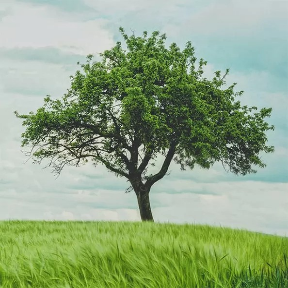
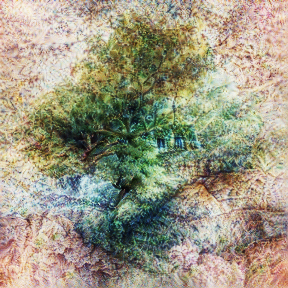

In [ ]:
# Caricature -> this needs caution for optimization instabilities, we must experiment more or implement another theoretical framework

layer_name = "layer4_5_conv3"

target_image = Image.open(data_path + "field.jpg")  # target image
transform_to_tensor = transforms.ToTensor()
target_image = transform_to_tensor(target_image).unsqueeze(0)
upsample = torch.nn.Upsample(size=(288, 288), mode='bilinear', align_corners=False)
target_image = upsample(target_image).squeeze(0).to(device)

image_path = f"results/feature_vis_caricature_{layer_name}_field.png"

obj = objectives.Objective.sum([
    1.0 * objectives.dot_compare(layer_name, cossim_pow=1.0),
    # -0.25 * objectives.blur_input_each_step()
    -0.1 * objectives.total_variation()
  ])

params, image_f = param.image(288)
def stacked_param_f():
  return params, lambda: torch.stack([target_image, image_f()[0]])

tforms = [ # we can experiment with these transformations
        transform.pad(2, mode='constant', constant_value=.5),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.random_scale([0.995**n for n in range(-5, 80)] + [0.998**n for n in 2 * list(range(20, 40))]),
        transform.random_rotate(list(range(-20, 20))+list(range(-10, 10))+list(range(-5, 5)) + 5 * [0]),
        transform.jitter(2)
]

# tforms = [
#         transform.pad(2, mode='constant', constant_value=.5),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.random_scale([0.995**n for n in range(-5, 80)] + [0.998**n for n in 2 * list(range(20, 40))]),
#         transform.random_rotate(list(range(-20, 20))+list(range(-10, 10))+list(range(-5, 5)) + 5 * [0]),
#         transform.jitter(2)
# ]

# tforms = [
#     transform.pad(8, mode='constant', constant_value=.5),
#     transform.jitter(8),
#     transform.random_scale([0.9, 0.95, 1.05, 1.1] + [1]*4),
#     transform.random_rotate(list(range(-5, 5)) + [0]*5),
#     transform.jitter(2),
# ]

_ = render.render_vis(vision_side, obj, stacked_param_f, transforms=tforms, show_inline=True, save_image=True, image_name=image_path, thresholds=(320,))

## Dataset samples

Here we find the top-k images in a dataset that maximally activate a given neuron/channel. We will experiment with the PACS, ImageNet, Office and COCO datasets.

### **PACS dataset**

In [ ]:
# Load the PACS dataset

pacs_ds = deeplake.load("hub://activeloop/pacs-train")

-

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/pacs-train



|

hub://activeloop/pacs-train loaded successfully.



In [ ]:
# Dataloader

tform = transforms.Compose([ # transforms
    transforms.ToPILImage(),
    preprocess # CLIP preprocessing
])

batch_size = 4 # batch size

dataloader = pacs_ds.pytorch(batch_size=batch_size, num_workers=0, # dataloader
    transform = {'images': tform, 'labels': None}, shuffle=True)

### **ImageNet dataset**

In [ ]:
# Load the ImageNet dataset

# Transformations
tform = transforms.Compose([
    # transforms.ToPILImage(),
    preprocess, # CLIP preprocessing
    # transforms.Resize(256),
    # transforms.CenterCrop(224),
    # transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# tform = transforms.Compose([
#     transforms.Resize((64, 64)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

batch_size = 4 # batch size

imagenet_data_path = data_path + 'tiny-imagenet-200'
train_imagenet_dataset = datasets.ImageFolder(imagenet_data_path + '/train', transform=tform)
train_imagenet_loader = DataLoader(train_imagenet_dataset, batch_size=batch_size, shuffle=True) # dataloader
dataloader = train_imagenet_loader

### **Office dataset**

In [ ]:
# Load the Office dataset (perhaps we should experiment with another more "appropriate" dataset)

# Transformations
tform = transforms.Compose([
    preprocess, # CLIP preprocessing
    # transforms.Resize((224, 224)),
    # transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = 4 # batch size

office_data_path = data_path + 'office'
amazon_dataset = datasets.ImageFolder(office_data_path + '/amazon', transform=tform)
webcam_dataset = datasets.ImageFolder(office_data_path + '/webcam', transform=tform)
dslr_dataset = datasets.ImageFolder(office_data_path + '/dslr', transform=tform)
office_dataset = ConcatDataset([amazon_dataset, webcam_dataset, dslr_dataset])
office_loader = DataLoader(office_dataset, batch_size=batch_size, shuffle=True) # dataloader
dataloader = office_loader

### **COCO dataset**

In [ ]:
# Load the COCO dataset

print(foz.list_zoo_datasets()) # list available zoo datasets

coco_dataset = foz.load_zoo_dataset("coco-2017", split="validation")

class COCODataset(Dataset):
    def __init__(self, fiftyone_dataset, transform=None):
        self.samples = []
        self.transform = transform

        for sample in fiftyone_dataset:
            self.samples.append(sample.filepath)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        filepath = self.samples[idx]
        image = Image.open(filepath)

        if self.transform:
            image = self.transform(image)

        return image

# Transformations
tform = transforms.Compose([
    preprocess, # CLIP preprocessing
    # transforms.Resize((224, 224)),
    # transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = 4 # batch size

coco_pytorch_dataset = COCODataset(coco_dataset, transform=tform)
coco_loader = DataLoader(coco_pytorch_dataset, batch_size=batch_size, shuffle=True) # dataloader
dataloader = coco_loader

['activitynet-100', 'activitynet-200', 'bdd100k', 'caltech101', 'caltech256', 'cifar10', 'cifar100', 'cityscapes', 'coco-2014', 'coco-2017', 'fashion-mnist', 'fiw', 'hmdb51', 'imagenet-2012', 'imagenet-sample', 'kinetics-400', 'kinetics-600', 'kinetics-700', 'kinetics-700-2020', 'kitti', 'kitti-multiview', 'lfw', 'mnist', 'open-images-v6', 'open-images-v7', 'quickstart', 'quickstart-geo', 'quickstart-groups', 'quickstart-video', 'sama-coco', 'ucf101', 'voc-2007', 'voc-2012']
Found annotations at '/home/angelos/fiftyone/coco-2017/raw/instances_val2017.json'
Images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [ ]:
# Top-k images/stimuli in the selected dataset that most activate a given neuron (channel)

activations = []
def get_activation(name):
  def hook(model, input, output):
    activations.append(output.detach())
  return hook

# Define the layer and channel
layer_number = getattr(vision_side, 'layer4')
block = layer_number[5]
layer = getattr(block, 'bn3')
neuron_index = 1512 # 1512 (bn3) is "happy", 1739 (conv3) is "evil"

hook = layer.register_forward_hook(get_activation('layer_4_5_bn3')) # hook

# Process the images and record the activations
max_batches = 1000 # number of batches

batch_count = 0
saved_images = []
with torch.no_grad():
  for inputs in dataloader:
    if batch_count >= max_batches:
      break

    # images = inputs['images'] # PACS
    # images = inputs[0] # ImageNet, Office
    images = inputs # COCO

    saved_images.extend(images.cpu().numpy())

    images = images.to(dtype=torch.float32, device=device)
    _ = vision_side(images)

    batch_count += 1

hook.remove()
activations = torch.cat(activations, dim=0)

# Top-k images in the dataset
k = 200
neuron_activations = activations[:, neuron_index].mean(dim=(1, 2))
top_image_indices = torch.argsort(neuron_activations, descending=True)[:k]
topk_images = [saved_images[i] for i in top_image_indices]
topk_activations = [activations[i, :].mean(dim=(1, 2)) for i in top_image_indices] # store the activations (averaging over the spatial dimensions of each channel)

# Show the top-k images
# fig, axes = plt.subplots(1, len(topk_images), figsize=(15, 5))
# if not isinstance(axes, (np.ndarray, list)):
#   axes = [axes]

# for i, image in enumerate(topk_images):
#   ax = axes[i]
#   ax.imshow(image.transpose(1, 2, 0))
#   # ax.imshow(image)
#   ax.set_title(f"Top-{i+1} image")
#   ax.axis('off')

# plt.savefig(f"results/dataset_samples_coco_west_africa.png") # save the fig

# plt.show()

## Faceted feature visualization

### **Multifaceted feature visualization**

100%|███████████████████████████████████████████████████| 512/512 [00:27<00:00, 18.50it/s]



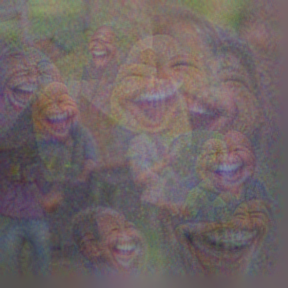

100%|███████████████████████████████████████████████████| 512/512 [00:28<00:00, 17.74it/s]



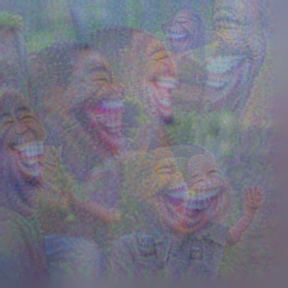

100%|███████████████████████████████████████████████████| 512/512 [00:24<00:00, 20.64it/s]



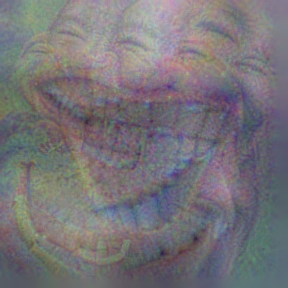

100%|███████████████████████████████████████████████████| 512/512 [00:25<00:00, 19.76it/s]



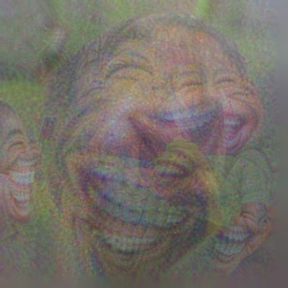

100%|███████████████████████████████████████████████████| 512/512 [00:28<00:00, 18.19it/s]



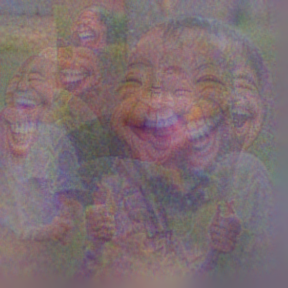

In [ ]:
# MFV (see https://arxiv.org/pdf/1602.03616.pdf) - we will also implement the center-biased regularization...

# The set of images U are the training set images that maximally activate a neuron/channel (top-k images found earlier)
facets = 5 # number of facets

# Extract high-level features for each image
# features = [activation.cpu().numpy() for activation in topk_activations] # we did it earlier (topk_activations), via averaging over the spatial dimensions of each channel (dim)
# , or we can try something different like:
with torch.no_grad():
  features = [model.encode_image(torch.from_numpy(image).unsqueeze(0).to(device)).squeeze(0).cpu().numpy() for image in topk_images] # final image embeddings

# Reduce dimensionality with PCA
pca = PCA(n_components=50)
features_pca = pca.fit_transform(np.vstack(features))

# Run t-SNE
tsne = TSNE(n_components=2)
features_tsne = tsne.fit_transform(features_pca)

# Clustering
kmeans = KMeans(n_clusters=facets)
clusters = kmeans.fit_predict(features_tsne)
distances = cdist(features_tsne, kmeans.cluster_centers_, metric='euclidean') # distances to centroids

# Mean images
m = 15 # average the top-m images per cluster
mean_images_initialization = []
for i in range(facets):
  cluster_indices = np.where(clusters == i)[0]
  cluster_distances = distances[cluster_indices, i]
  closest_indices = cluster_indices[np.argsort(cluster_distances)[:m]]
  cluster_images = [topk_images[i] for i in closest_indices]
  mean_image = np.mean(cluster_images, axis=0)
  mean_images_initialization.append(mean_image)

# Feature visualization
layer_name = "layer4_5_bn3"
neuron_channel_index = 1512 # 1739 is evil, 1512 is happy, 89 is the "Donald Trump neuron"

# obj = objectives.channel(layer_name, neuron_channel_index) # objective, we can experiment more
# obj -= 1e-3 * objectives.L2()
# obj -= 0.25 * objectives.total_variation()
# obj -= 1.0 * objectives.blur_input_each_step()
obj = objectives.Objective.sum([
    objectives.channel(layer_name, neuron_channel_index),
    # -1e-3 * objectives.L2()
    -0.25 * objectives.total_variation(),
    # -1.0 * objectives.blur_input_each_step()
  ])

tforms = [ # we can experiment with these transformations
        transform.pad(2, mode='constant', constant_value=.5),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.random_scale([0.995**n for n in range(-5, 80)] + [0.998**n for n in 2 * list(range(20, 40))]),
        transform.random_rotate(list(range(-20, 20))+list(range(-10, 10))+list(range(-5, 5)) + 5 * [0]),
        transform.jitter(2)
]

for i, initialization in enumerate(mean_images_initialization):
  image_path = f"results/multifaceted_feature_vis_coco_{layer_name}_{neuron_channel_index}_facet_{i+1}.png"
  transform_to_tensor = transforms.ToTensor()
  initialization = transform_to_tensor(initialization).unsqueeze(0).permute(0, 2, 3, 1).to(device).requires_grad_(True)
  def param_f(): # initialization
    return [initialization], to_valid_rgb(lambda: initialization, decorrelate=False)

  _ = render.render_vis(vision_side, obj, param_f, transforms=tforms, show_inline=True, save_image=True, image_name=image_path, thresholds=(512,))

### **Diversity objective**

100%|███████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.10it/s]



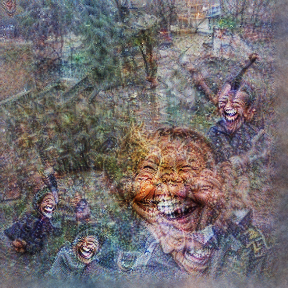
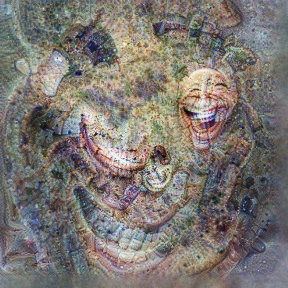

In [ ]:
# Diversity objective

layer_name = "layer4_5_bn3"
neuron_channel_index = 1512 # 1739 is evil, 1512 is happy
image_path = f"results/feature_vis_diversity_{layer_name}_{neuron_channel_index}.png"

batch_param_f = lambda: param.image(288, batch=2, decorrelate=True)
obj = objectives.channel(layer_name, neuron_channel_index) - 1.5 * objectives.diversity(layer_name) # we sgould experiment more

tforms = [ # we can experiment with these transformations
        transform.pad(2, mode='constant', constant_value=.5),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.random_scale([0.995**n for n in range(-5, 80)] + [0.998**n for n in 2 * list(range(20, 40))]),
        transform.random_rotate(list(range(-20, 20))+list(range(-10, 10))+list(range(-5, 5)) + 5 * [0]),
        transform.jitter(2)
]

_ = render.render_vis(vision_side, obj, batch_param_f, transforms=tforms, show_inline=True, save_image=True, image_name=image_path, thresholds=(100,))

### **OpenAI faceted feature visualization**

In [ ]:
# Let's try the OpenAI faceted feature visualization (e.g. https://github.com/openai/CLIP-featurevis/blob/master/example_facets.py)

# I will write the code shortly... (we should send an email to the authors for the links or implement the style attrs, or fuck it)

layer_name = "layer4_5_bn3"
neuron_channel_index = 1512 # 1739 is evil, 1512 is happy, 89 is the "Donald Trump neuron"
image_path = f"results/openai_faceted_feature_vis_{layer_name}_{neuron_channel_index}.png"

def load_npy(url): # load style attrs from urls
  response = requests.get(url)
  response.raise_for_status()
  return np.load(BytesIO(response.content))

facets = ["face", "text", "logo", "pose", "arch", "nature", "indoor"] # facets
style_attrs = [load_npy(f"https://openaipublic.blob.core.windows.net/clip/facets/RN50_4x/{layer_name}/{facet}_spatial.npy") for facet in facets] # style attributes (the urls doesn't work!)

batch_param_f = lambda: param.image(288, batch=1, decorrelate=True, alpha=True)
obj = objectives.channel(layer_name, neuron_channel_index) # objective
obj -= 1e2 * objectives.blur_alpha_each_step()
# ...

tforms = [ # we can experiment with these transformations
        transform.pad(2, mode='constant', constant_value=.5),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.random_scale([0.995**n for n in range(-5, 80)] + [0.998**n for n in 2 * list(range(20, 40))]),
        transform.random_rotate(list(range(-20, 20))+list(range(-10, 10))+list(range(-5, 5)) + 5 * [0]),
        transform.jitter(2),
        transform.collapse_alpha_random()
]

_ = render.render_vis(vision_side, obj, batch_param_f, transforms=tforms, show_inline=True, save_image=True, image_name=image_path, thresholds=(512,))

## Text feature visualization

In [ ]:
# We will write the code shortly...

# 1st idea: optimization in input embeddings and clustering to transform them into tokens
# 2nd idea: greedy heuristic algorithm (e.g. hill climbing) and LM -> we will implement this

## Semantic relations in multimodal models

In [ ]:
# Semantic relation of image-based word embeddings

# Rastering words into images
def text_to_image(text, font_size=40, image_size=(288, 288)):
  try:
    font = ImageFont.truetype("arial.ttf", font_size)
  except IOError:
    print("Arial font not found, using default font.")
    font = ImageFont.load_default()

  image = Image.new("RGB", image_size, "white")
  draw = ImageDraw.Draw(image)
  _, _, text_width, text_height = draw.textbbox((0, 0), text=text, font=font)
  text_top = (image_size[1] - text_height) // 2
  text_left = (image_size[0] - text_width) // 2
  draw.text((text_left, text_top), text, fill="black", font=font)
  return image

def text_to_tensor(text, font_size=40, image_size=(288, 288)):
  image = text_to_image(text, font_size=font_size, image_size=image_size)
  return preprocess(image).unsqueeze(0).to(device)

# Words to rasterize and compare
# vocabulary = words.words()[:500] # from nltk
# or "manually":
vocabulary = ["texas", "guns", "white", "supremacy", "terrorist", "muslim", "bush", "joe biden", "fell down", "dimentia", "sleepy", "car", "america", "donald trump", "republicans", "water", "lake", "god", "bible", "motorcycle", "wall", "us", "thank you", "merci", "france", "london", "paris", "england", "europe", "mike pence"]

word_tensors = torch.cat([text_to_tensor(word) for word in vocabulary], dim=0)
with torch.no_grad(): # image-based embeddings
  rasterized_text_embeddings = model.encode_image(word_tensors)

text_inputs = clip.tokenize(vocabulary).to(device)
with torch.no_grad(): # word embeddings
  real_text_embeddings = model.encode_text(text_inputs)

In [ ]:
# Find the most semantically close (similar) words based on the cosine similarity for the target word (top-k)

target_word = "guns"
target_word_index = vocabulary.index(target_word)
target_word_embedding = rasterized_text_embeddings[target_word_index].unsqueeze(0)
cosine_similarities_rasterized = torch.nn.functional.cosine_similarity(target_word_embedding, rasterized_text_embeddings)
cosine_similarities_real_text = torch.nn.functional.cosine_similarity(target_word_embedding, real_text_embeddings)

k = 5
sorted_indices_rasterized = torch.argsort(cosine_similarities_rasterized, descending=True)
sorted_indices_real_text = torch.argsort(cosine_similarities_real_text, descending=True)

print(f"Top-{k} similar words to '{target_word}' in rasterized text:")
for i in range(1, k + 1):
  index = sorted_indices_rasterized[i].item()
  print(f"{vocabulary[index]}: {cosine_similarities_rasterized[index].item()}")

print(f"\nTop-{k} similar words to '{target_word}' in real text:")
for i in range(1, k + 1):
  index = sorted_indices_real_text[i].item()
  print(f"{vocabulary[index]}: {cosine_similarities_real_text[index].item()}")

# We should discuss about the modality gap problem, based also on our results/findings here

Top-5 similar words to 'guns' in rasterized text:
terrorist: 0.87841796875
white: 0.8720703125
wall: 0.86865234375
god: 0.8603515625
bush: 0.85400390625

Top-5 similar words to 'guns' in real text:
america: 0.3603515625
texas: 0.352783203125
god: 0.350341796875
bible: 0.349853515625
thank you: 0.349609375


In [ ]:
# Word arithmetic - analogies (a:b::a∗:b∗, a is to b as a∗ is to b∗ - parallelogram method)

a = "paris"
b = "france"
a_star = "london"
a_index = vocabulary.index(a)
b_index = vocabulary.index(b)
a_star_index = vocabulary.index(a_star)
a_embedding = rasterized_text_embeddings[a_index].unsqueeze(0)
b_embedding = rasterized_text_embeddings[b_index].unsqueeze(0)
a_star_embedding = rasterized_text_embeddings[a_star_index].unsqueeze(0)
cosine_similarities_rasterized = torch.nn.functional.cosine_similarity(b_embedding - a_embedding + a_star_embedding, rasterized_text_embeddings)

# Find the top-m results for the analogy
m = 5
sorted_indices_rasterized = torch.argsort(cosine_similarities_rasterized, descending=True)
print(f"{a} is to {b} as {a_star} is to:")
for i in range(1, m + 1):
  index = sorted_indices_rasterized[i].item()
  print(f"{vocabulary[index]}: {cosine_similarities_rasterized[index].item()}")

# We can experiment also with mixed arithmetic of words and images

paris is to france as london is to:
england: 0.87109375
france: 0.87060546875
europe: 0.81689453125
merci: 0.7783203125
us: 0.77734375


## Emotion composition

In [ ]:
# We will write the code shortly... (if time permits)

## CLAP model

In general, we plan to explore similar undiscovered multimodal neurons that may exist in other models as well, such as **audio** and **music** understanding, and also not limited to contrastive learning approaches and retrieval models.

Here, we will try to explore multimodal neurons in the CLAP (https://arxiv.org/pdf/2206.04769.pdf) model.

In [ ]:
# CLAP model

# MS CLAP
model, tokenizer, args = CLAP(version='2023', use_cuda=True).load_clap() # -> changed the config file to use the Cnn14 architecture

# LAION CLAP
# model = laion_clap.CLAP_Module(enable_fusion=False, device=device) # -> the audio side here is implemented with transformers
# model.load_ckpt()

model.to(device).eval()

CLAP(
  (audio_encoder): AudioEncoder(
    (base): Cnn14(
      (spectrogram_extractor): Spectrogram(
        (stft): STFT(
          (conv_real): Conv1d(1, 513, kernel_size=(1024,), stride=(320,), bias=False)
          (conv_imag): Conv1d(1, 513, kernel_size=(1024,), stride=(320,), bias=False)
        )
      )
      (logmel_extractor): LogmelFilterBank()
      (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_block1): ConvBlock(
        (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_block2): ConvBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [ ]:
# Audio side of the CLAP model

# audio_side = model.model.audio_branch # LAION CLAP
audio_side = model.audio_encoder # MS CLAP

In [ ]:
# Audio side model layers

layers = get_model_layers(audio_side)
print(layers)

['base', 'base_spectrogram_extractor', 'base_spectrogram_extractor_stft', 'base_spectrogram_extractor_stft_conv_real', 'base_spectrogram_extractor_stft_conv_imag', 'base_logmel_extractor', 'base_bn0', 'base_conv_block1', 'base_conv_block1_conv1', 'base_conv_block1_conv2', 'base_conv_block1_bn1', 'base_conv_block1_bn2', 'base_conv_block2', 'base_conv_block2_conv1', 'base_conv_block2_conv2', 'base_conv_block2_bn1', 'base_conv_block2_bn2', 'base_conv_block3', 'base_conv_block3_conv1', 'base_conv_block3_conv2', 'base_conv_block3_bn1', 'base_conv_block3_bn2', 'base_conv_block4', 'base_conv_block4_conv1', 'base_conv_block4_conv2', 'base_conv_block4_bn1', 'base_conv_block4_bn2', 'base_conv_block5', 'base_conv_block5_conv1', 'base_conv_block5_conv2', 'base_conv_block5_bn1', 'base_conv_block5_bn2', 'base_conv_block6', 'base_conv_block6_conv1', 'base_conv_block6_conv2', 'base_conv_block6_bn1', 'base_conv_block6_bn2', 'base_fc1', 'base_fc_audioset', 'projection', 'projection_linear1', 'projection

In [ ]:
# Define the layer and neuron/channel for feature visualization -> this doesn't work, we will find a way to play with audio and specs or through the VL-InterpreT tool

# We will write the code shortly...

layer_name = "base_conv_block6_bn2"
neuron_channel_index = 6

batch_param_f = lambda: param.image(256, batch=1, decorrelate=True)
obj = objectives.neuron(layer_name, neuron_channel_index)

_ = render.render_vis(audio_side, obj, batch_param_f, show_inline=True)
# _ = render.render_vis(audio_side, "layer3_3_conv3:168", show_inline=True) # or this

## Interpretability in transformer-based encoders

In [57]:
# We will write the code shortly...

# TODO:
# - attention and hidden states in synthetic or natural images with multiple related (multimodal) concepts for the CLIP ViT model
#   * robustness at fonts and font size
#   * text in natural images (e.g. signs)
#   * experiment only with text, e.g. -ing detectors, semantics, etc.
#   * interleaved synthetic text to image (blended, robustness)
#   * experiment with patch size (resolution)
#   * instead of "neurons" (channels in cnn architectures) find heads that capture a semantic space (e.g. -ing detector, high-level semantics, etc.)
#   * why and how this works? needs further discussion and insights
#   * image-to-text and text-to-image attention isn't "symmetric"
#   * "perceptive field" (attendance in bigger scale) changes as we go deeper
#   * we see that text attends at first layers to itself and other texts (probably of background, font, different pixel space in rastered text than the natural image)
#   * again, why this is working? and does it depend on the dataset CLIP was trained on (natural text in images and contrastive objective, similar concepts "brought" together)?

# - interpretability of cross-modal attentions for "true" multimodal models, e.g. MuLaP or ViLBERT

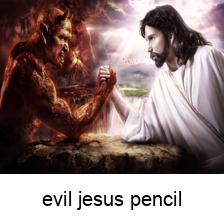

In [56]:
# Create a synthetic image with rastered text caption having multiple related (multimodal) concepts

def combine_image_with_caption(true_image_path, caption, combined_image_path, font_size=20, image_size=(224, 224), caption_height=50):
  true_image = Image.open(true_image_path)
  true_image_resized = true_image.resize((image_size[0], image_size[1] - caption_height))
  caption_image = text_to_image(caption, font_size, (image_size[0], caption_height))
  combined_image = Image.new("RGB", image_size, "white")
  combined_image.paste(true_image_resized, (0, 0))
  combined_image.paste(caption_image, (0, image_size[1] - caption_height))
  combined_image.save(combined_image_path)

  return combined_image

combine_image_with_caption(data_path + "evil_jesus.jpg", "evil jesus pencil", data_path + "evil_jesus_captioned.jpg")